# <center> 【Kaggle】Telco Customer Churn

In [ ]:
# 基础数据科学运算库
import numpy as np
import pandas as pd

# 可视化库
import seaborn as sns
import matplotlib.pyplot as plt

# 时间模块
import time

# sklearn库
# 数据预处理
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# 实用函数
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

# 常用评估器
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# 网格搜索
from sklearn.model_selection import GridSearchCV

# 自定义评估器支持模块
from sklearn.base import BaseEstimator, TransformerMixin

# 自定义模块
from telcoFunc import *
# 导入特征衍生模块
import features_creation as fc
from features_creation import *

# re模块相关
import inspect, re

# 其他模块
from tqdm import tqdm
import gc

In [ ]:
# 读取数据
tcc = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# 标注连续/离散字段
# 离散字段
category_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
                'PaymentMethod']

# 连续字段
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# 标签
target = 'Churn'

# ID列
ID_col = 'customerID'

# 验证是否划分能完全
assert len(category_cols) + len(numeric_cols) + 2 == tcc.shape[1]

# 连续字段转化
tcc['TotalCharges']= tcc['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)
tcc['MonthlyCharges'] = tcc['MonthlyCharges'].astype(float)

# 缺失值填补
tcc['TotalCharges'] = tcc['TotalCharges'].fillna(0)

# 标签值手动转化
tcc['Churn'].replace(to_replace='Yes', value=1, inplace=True)
tcc['Churn'].replace(to_replace='No',  value=0, inplace=True)

In [ ]:
features = tcc.drop(columns=[ID_col, target]).copy()
labels = tcc['Churn'].copy()

In [ ]:
# 划分训练集和测试集
train, test = train_test_split(tcc, random_state=22)

X_train = train.drop(columns=[ID_col, target]).copy()
X_test = test.drop(columns=[ID_col, target]).copy()

y_train = train['Churn'].copy()
y_test = test['Churn'].copy()

X_train_seq = pd.DataFrame()
X_test_seq = pd.DataFrame()

# 年份衍生
X_train_seq['tenure_year'] = ((72 - X_train['tenure']) // 12) + 2014
X_test_seq['tenure_year'] = ((72 - X_test['tenure']) // 12) + 2014

# 月份衍生
X_train_seq['tenure_month'] = (72 - X_train['tenure']) % 12 + 1
X_test_seq['tenure_month'] = (72 - X_test['tenure']) % 12 + 1

# 季度衍生
X_train_seq['tenure_quarter'] = ((X_train_seq['tenure_month']-1) // 3) + 1
X_test_seq['tenure_quarter'] = ((X_test_seq['tenure_month']-1) // 3) + 1

# 独热编码
enc = preprocessing.OneHotEncoder()
enc.fit(X_train_seq)

seq_new = list(X_train_seq.columns)

# 创建带有列名称的独热编码之后的df
X_train_seq = pd.DataFrame(enc.transform(X_train_seq).toarray(),
                           columns = cate_colName(enc, seq_new, drop=None))

X_test_seq = pd.DataFrame(enc.transform(X_test_seq).toarray(),
                          columns = cate_colName(enc, seq_new, drop=None))

# 调整index
X_train_seq.index = X_train.index
X_test_seq.index = X_test.index

In [ ]:
ord_enc = OrdinalEncoder()
ord_enc.fit(X_train[category_cols])

X_train_OE = pd.DataFrame(ord_enc.transform(X_train[category_cols]), columns=category_cols)
X_train_OE.index = X_train.index
X_train_OE = pd.concat([X_train_OE, X_train[numeric_cols]], axis=1)

X_test_OE = pd.DataFrame(ord_enc.transform(X_test[category_cols]), columns=category_cols)
X_test_OE.index = X_test.index
X_test_OE = pd.concat([X_test_OE, X_test[numeric_cols]], axis=1)

In [ ]:
def MissingValueThreshold(X_train_temp, X_test_temp, threshold = 0.9, fn = 0):
    """
    根据比例删除缺失值比例较高的特征
    同时将其他缺失值统一填补为fn的值

    :param X_train_temp: 训练集特征
    :param X_test_temp: 测试集特征
    :param threshold: 缺失值比例阈值
    :param fn: 其他缺失值填补数值

    :return：剔除指定特征后的X_train_temp和X_test_temp
    """
    for col in X_train_temp:
        if X_train_temp[col].isnull().sum() / X_train_temp.shape[0] >= threshold:
            del X_train_temp[col]
            del X_test_temp[col]
        else:
            X_train_temp[col] = X_train_temp[col].fillna(fn)
            X_test_temp[col] = X_test_temp[col].fillna(fn)
    return X_train_temp, X_test_temp

In [ ]:
df_train = pd.DataFrame({'x1':[1, np.nan, np.nan], 'x2':[1, 2, np.nan], 'X3':[1, 2, 3]})

In [ ]:
df_test = df_train.copy()

In [ ]:
df_test

,x1,x2,X3
0,1.0,1.0,1
1,NaN,2.0,2
2,NaN,NaN,3


In [ ]:
df_test.isnull().sum()

x1    2
x2    1
X3    0
dtype: int64

In [ ]:
X_train, X_test = MissingValueThreshold(df_train, df_test, threshold = 0.5)
X_test

,x2,X3
0,1.0,1
1,2.0,2
2,0.0,3


In [ ]:
df_temp = pd.DataFrame({'x1':[1, 2, 4], 'x2':[1, 2, 1], 'x3':[1, 1, 1]})
df_temp

,x1,x2,x3
0,1,1,1
1,2,2,1
2,4,1,1


In [ ]:
df_temp.var()

x1    2.333333
x2    0.333333
x3    0.000000
dtype: float64

In [ ]:
np.power((df_temp['x1'] - df_temp['x1'].mean()), 2).sum() / 2

2.333333333333333

In [ ]:
df_temp.var(ddof=0)

x1    1.555556
x2    0.222222
x3    0.000000
dtype: float64

In [ ]:
np.power((df_temp['x1'] - df_temp['x1'].mean()), 2).sum() / 3

1.5555555555555554

In [ ]:
# 而默认情况下，相当于自由度-1
df_temp.var(ddof=1)

x1    2.333333
x2    0.333333
x3    0.000000
dtype: float64

In [ ]:
VarianceThreshold?

Init signature: VarianceThreshold(threshold=0.0)
Docstring:     
Feature selector that removes all low-variance features.

This feature selection algorithm looks only at the features (X), not the
desired outputs (y), and can thus be used for unsupervised learning.

Read more in the :ref:`User Guide <variance_threshold>`.

Parameters
----------
threshold : float, default=0
    Features with a training-set variance lower than this threshold will
    be removed. The default is to keep all features with non-zero variance,
    i.e. remove the features that have the same value in all samples.

Attributes
----------
variances_ : array, shape (n_features,)
    Variances of individual features.

n_features_in_ : int
    Number of features seen during :term:`fit`.

    .. versionadded:: 0.24

feature_names_in_ : ndarray of shape (`n_features_in_`,)
    Names of features seen during :term:`fit`. Defined only when `X`
    has feature names that are all strings.

    .. versionadded:: 1.0

See Also

In [ ]:
# 实例化评估器
sel = VarianceThreshold(threshold=1.5)

In [ ]:
# 训练评估器，对数据集进行修改
sel.fit_transform(df_temp)

array([[1],
       [2],
       [4]], dtype=int64)

In [ ]:
# sel = VarianceThreshold(threshold=1.6)
# sel.fit_transform(df_temp)

In [ ]:
df_temp.var(ddof=0)

x1    1.555556
x2    0.222222
x3    0.000000
dtype: float64

In [ ]:
df_temp

,x1,x2,x3
0,1,1,1
1,2,2,1
2,4,1,1


In [ ]:
sel = VarianceThreshold()
sel.fit_transform(df_temp)

array([[1, 1],
       [2, 2],
       [4, 1]], dtype=int64)

In [ ]:
sel.variances_

array([1.55555556, 0.22222222, 0.        ])

In [ ]:
sel.variances_ == 0

array([False, False,  True])

In [ ]:
df_temp.columns

Index(['x1', 'x2', 'x3'], dtype='object')

In [ ]:
df_temp.columns[sel.variances_ != 0]

Index(['x1', 'x2'], dtype='object')

In [ ]:
df_temp[df_temp.columns[sel.variances_ != 0]]

,x1,x2
0,1,1
1,2,2
2,4,1


In [ ]:
(df_temp['x1']).var(ddof=0)

1.5555555555555554

In [ ]:
(df_temp['x1'] * 10).var(ddof=0)

155.55555555555557

In [ ]:
df_temp1 = pd.DataFrame(preprocessing.scale(df_temp), columns=df_temp.columns)
df_temp1

,x1,x2,x3
0,-1.069045,-0.707107,0.0
1,-0.267261,1.414214,0.0
2,1.336306,-0.707107,0.0


In [ ]:
df_temp.var(ddof=0)

x1    1.555556
x2    0.222222
x3    0.000000
dtype: float64

In [ ]:
df_temp1.var(ddof=0)

x1    1.0
x2    1.0
x3    0.0
dtype: float64

In [ ]:
df_temp1 = pd.DataFrame(preprocessing.minmax_scale(df_temp), columns=df_temp.columns)
df_temp1

,x1,x2,x3
0,0.000000,0.0,0.0
1,0.333333,1.0,0.0
2,1.000000,0.0,0.0


In [ ]:
df_temp1.var(ddof=0)

x1    0.172840
x2    0.222222
x3    0.000000
dtype: float64

In [ ]:
df_temp = pd.DataFrame({'x1':[0, 0, 1, 1, 1, 0], 'x2':[1, 1, 1, 1, 0, 0], 'x3':[0, 0, 0, 0, 1, 0], 'x4':[0, 0, 0, 0, 0, 0]})
df_temp

,x1,x2,x3,x4
0,0,1,0,0
1,0,1,0,0
2,1,1,0,0
3,1,1,0,0
4,1,0,1,0
5,0,0,0,0


In [ ]:
df_temp['x2']

0    1
1    1
2    1
3    1
4    0
5    0
Name: x2, dtype: int64

In [ ]:
2/6 * (1-2/6)

0.22222222222222224

In [ ]:
df_temp['x1']

0    0
1    0
2    1
3    1
4    1
5    0
Name: x1, dtype: int64

In [ ]:
# x2列方差
1/2 * (1-1/2)

0.25

In [ ]:
df_temp['x3']

0    0
1    0
2    0
3    0
4    1
5    0
Name: x3, dtype: int64

In [ ]:
# x2列方差
1/6 * (1-1/6)

0.1388888888888889

In [ ]:
3/10 * (1-3/10)

0.21

In [ ]:
df_temp

,x1,x2,x3,x4
0,0,1,0,0
1,0,1,0,0
2,1,1,0,0
3,1,1,0,0
4,1,0,1,0
5,0,0,0,0


In [ ]:
sel = VarianceThreshold(threshold=0.21)
sel.fit_transform(df_temp)

array([[0, 1],
       [0, 1],
       [1, 1],
       [1, 1],
       [1, 0],
       [0, 0]], dtype=int64)

In [ ]:
sel.variances_

array([0.25      , 0.22222222, 0.13888889, 0.        ])

In [ ]:
# 查看保留列的df
df_temp[df_temp.columns[sel.variances_ > 0.21]]

,x1,x2
0,0,1
1,0,1
2,1,1
3,1,1
4,1,0
5,0,0


In [ ]:
sel = VarianceThreshold()
sel.fit_transform(df_temp)

array([[0, 1, 0],
       [0, 1, 0],
       [1, 1, 0],
       [1, 1, 0],
       [1, 0, 1],
       [0, 0, 0]], dtype=int64)

In [ ]:
# 经过自然数编码的训练集数据
X_train_OE.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,tenure,MonthlyCharges,TotalCharges
4067,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,1.0,0.0,68,79.60,5515.80
3306,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,3,80.00,241.30
3391,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,4,19.00,73.45
3249,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,10,55.55,551.30
2674,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,4,20.05,91.45


In [ ]:
# 计算相关系数
df_temp = pd.concat([X_train_OE, y_train], axis=1)
df_corr = df_temp.corr()['Churn']
df_corr

gender             -0.018605
SeniorCitizen       0.140164
Partner            -0.159577
Dependents         -0.152544
PhoneService       -0.002501
MultipleLines       0.031559
InternetService    -0.054444
OnlineSecurity     -0.307484
OnlineBackup       -0.197237
DeviceProtection   -0.191164
TechSupport        -0.288867
StreamingTV        -0.039879
StreamingMovies    -0.050142
Contract           -0.394464
PaperlessBilling    0.186661
PaymentMethod       0.116375
tenure             -0.357263
MonthlyCharges      0.181830
TotalCharges       -0.210238
Churn               1.000000
Name: Churn, dtype: float64

In [ ]:
from sklearn.feature_selection import r_regression

In [ ]:
r_regression(X_train_OE, y_train)

array([-0.01860513,  0.14016383, -0.15957745, -0.15254382, -0.00250081,
        0.0315595 , -0.05444391, -0.30748405, -0.19723667, -0.19116379,
       -0.2888665 , -0.03987906, -0.05014176, -0.39446444,  0.18666114,
        0.11637491, -0.35726337,  0.18182966, -0.21023844])

In [ ]:
from sklearn.feature_selection import SelectKBest

In [ ]:
SelectKBest?

Init signature: SelectKBest(score_func=<function f_classif at 0x000001D4349A6E50>, *, k=10)
Docstring:     
Select features according to the k highest scores.

Read more in the :ref:`User Guide <univariate_feature_selection>`.

Parameters
----------
score_func : callable, default=f_classif
    Function taking two arrays X and y, and returning a pair of arrays
    (scores, pvalues) or a single array with scores.
    Default is f_classif (see below "See Also"). The default function only
    works with classification tasks.

    .. versionadded:: 0.18

k : int or "all", default=10
    Number of top features to select.
    The "all" option bypasses selection, for use in a parameter search.

Attributes
----------
scores_ : array-like of shape (n_features,)
    Scores of features.

pvalues_ : array-like of shape (n_features,)
    p-values of feature scores, None if `score_func` returned only scores.

n_features_in_ : int
    Number of features seen during :term:`fit`.

    .. versionadded:: 

In [ ]:
KB = SelectKBest(r_regression, k=10)

In [ ]:
X_new = KB.fit_transform(X_train_OE, y_train)
X_new.shape

(5282, 10)

In [ ]:
X_new[:5]

array([[ 0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  2.  ,  2.  ,  1.  ,  0.  ,
        79.6 ],
       [ 0.  ,  0.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  2.  ,
        80.  ],
       [ 1.  ,  0.  ,  1.  ,  0.  ,  2.  ,  1.  ,  1.  ,  0.  ,  3.  ,
        19.  ],
       [ 0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  3.  ,
        55.55],
       [ 0.  ,  1.  ,  1.  ,  0.  ,  2.  ,  1.  ,  1.  ,  0.  ,  3.  ,
        20.05]])

In [ ]:
# 输入的所有特征
KB.feature_names_in_

array(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'tenure', 'MonthlyCharges', 'TotalCharges'], dtype=object)

In [ ]:
# 每个特征相关系数
KB.scores_

array([-0.01860513,  0.14016383, -0.15957745, -0.15254382, -0.00250081,
        0.0315595 , -0.05444391, -0.30748405, -0.19723667, -0.19116379,
       -0.2888665 , -0.03987906, -0.05014176, -0.39446444,  0.18666114,
        0.11637491, -0.35726337,  0.18182966, -0.21023844])

In [ ]:
# 每个特征的p值，目前返回结果为None
KB.pvalues_

In [ ]:
KB.k

10

In [ ]:
sorted(KB.scores_, reverse=True)[:10]

[0.18666114409941312,
 0.1818296585911835,
 0.1401638312930749,
 0.11637491358418606,
 0.031559498813656606,
 -0.0025008080096673483,
 -0.018605127155478008,
 -0.03987905886854042,
 -0.05014175688732029,
 -0.05444390781636287]

In [ ]:
threshold = sorted(KB.scores_, reverse=True)[9]
threshold

-0.05444390781636287

In [ ]:
KB.scores_

array([-0.01860513,  0.14016383, -0.15957745, -0.15254382, -0.00250081,
        0.0315595 , -0.05444391, -0.30748405, -0.19723667, -0.19116379,
       -0.2888665 , -0.03987906, -0.05014176, -0.39446444,  0.18666114,
        0.11637491, -0.35726337,  0.18182966, -0.21023844])

In [ ]:
KB.feature_names_in_

array(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'tenure', 'MonthlyCharges', 'TotalCharges'], dtype=object)

In [ ]:
for i in zip(KB.scores_, KB.feature_names_in_):
    print(i)

(-0.018605127155478008, 'gender')
(0.1401638312930749, 'SeniorCitizen')
(-0.1595774481386036, 'Partner')
(-0.15254381815342433, 'Dependents')
(-0.0025008080096673483, 'PhoneService')
(0.031559498813656606, 'MultipleLines')
(-0.05444390781636287, 'InternetService')
(-0.30748404756970066, 'OnlineSecurity')
(-0.19723667022421654, 'OnlineBackup')
(-0.19116379106171, 'DeviceProtection')
(-0.2888665015816091, 'TechSupport')
(-0.03987905886854042, 'StreamingTV')
(-0.05014175688732029, 'StreamingMovies')
(-0.39446444163483935, 'Contract')
(0.18666114409941312, 'PaperlessBilling')
(0.11637491358418606, 'PaymentMethod')
(-0.3572633742522449, 'tenure')
(0.1818296585911835, 'MonthlyCharges')
(-0.21023844378550435, 'TotalCharges')


In [ ]:
col_names = []

for i in zip(KB.scores_, KB.feature_names_in_):
    if i[0] >= threshold:
        col_names.append(i[1])

In [ ]:
col_names

['gender',
 'SeniorCitizen',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'StreamingTV',
 'StreamingMovies',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges']

In [ ]:
X_train_OE[col_names].head()

,gender,SeniorCitizen,PhoneService,MultipleLines,InternetService,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod,MonthlyCharges
4067,0.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,79.60
3306,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,80.00
3391,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,3.0,19.00
3249,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,55.55
2674,0.0,1.0,1.0,0.0,2.0,1.0,1.0,0.0,3.0,20.05


In [ ]:
X_new[:5]

array([[ 0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  2.  ,  2.  ,  1.  ,  0.  ,
        79.6 ],
       [ 0.  ,  0.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  2.  ,
        80.  ],
       [ 1.  ,  0.  ,  1.  ,  0.  ,  2.  ,  1.  ,  1.  ,  0.  ,  3.  ,
        19.  ],
       [ 0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  3.  ,
        55.55],
       [ 0.  ,  1.  ,  1.  ,  0.  ,  2.  ,  1.  ,  1.  ,  0.  ,  3.  ,
        20.05]])

In [ ]:
(X_train_OE[col_names] != X_new).sum()

gender              0
SeniorCitizen       0
PhoneService        0
MultipleLines       0
InternetService     0
StreamingTV         0
StreamingMovies     0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
dtype: int64

In [ ]:
X_train_new = pd.DataFrame(X_new, columns=col_names)
X_train_new.head(5)

,gender,SeniorCitizen,PhoneService,MultipleLines,InternetService,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod,MonthlyCharges
0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,79.60
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,80.00
2,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,3.0,19.00
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,55.55
4,0.0,1.0,1.0,0.0,2.0,1.0,1.0,0.0,3.0,20.05


In [ ]:
def SelectName(KB):
    """
    根据特征筛选评估器进行列名称输出函数

    :param KB: 训练后的BestK特征筛选评估器

    :return：保留特征的列名称
    """
    threshold = sorted(KB.scores_, reverse=True)[KB.k - 1]

    col_names = []

    for score, col in zip(KB.scores_, KB.feature_names_in_):
        if score >= threshold:
            col_names.append(col)

    return col_names

测试函数性能：

In [ ]:
SelectName(KB)

['gender',
 'SeniorCitizen',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'StreamingTV',
 'StreamingMovies',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges']

In [ ]:
from sklearn.feature_selection import f_regression
f_regression?

Signature: f_regression(X, y, *, center=True)
Docstring:
Univariate linear regression tests returning F-statistic and p-values.

Quick linear model for testing the effect of a single regressor,
sequentially for many regressors.

This is done in 2 steps:

1. The cross correlation between each regressor and the target is computed,
   that is, ((X[:, i] - mean(X[:, i])) * (y - mean_y)) / (std(X[:, i]) *
   std(y)) using r_regression function.
2. It is converted to an F score and then to a p-value.

:func:`f_regression` is derived from :func:`r_regression` and will rank
features in the same order if all the features are positively correlated
with the target.

Note however that contrary to :func:`f_regression`, :func:`r_regression`
values lie in [-1, 1] and can thus be negative. :func:`f_regression` is
therefore recommended as a feature selection criterion to identify
potentially predictive feature for a downstream classifier, irrespective of
the sign of the association with the target vari

<center><img src="https://s2.loli.net/2022/03/24/koawm45Ltqp8QB7.png" alt="image-20220324152933797" style="zoom:50%;" />

In [ ]:
# 相关系数取绝对值后降序排列
np.abs(df_corr).sort_values(ascending=False)

Churn               1.000000
Contract            0.394464
tenure              0.357263
OnlineSecurity      0.307484
TechSupport         0.288867
TotalCharges        0.210238
OnlineBackup        0.197237
DeviceProtection    0.191164
PaperlessBilling    0.186661
MonthlyCharges      0.181830
Partner             0.159577
Dependents          0.152544
SeniorCitizen       0.140164
PaymentMethod       0.116375
InternetService     0.054444
StreamingMovies     0.050142
StreamingTV         0.039879
MultipleLines       0.031559
gender              0.018605
PhoneService        0.002501
Name: Churn, dtype: float64

In [ ]:
r_regression(X_train_OE, y_train)

array([-0.01860513,  0.14016383, -0.15957745, -0.15254382, -0.00250081,
        0.0315595 , -0.05444391, -0.30748405, -0.19723667, -0.19116379,
       -0.2888665 , -0.03987906, -0.05014176, -0.39446444,  0.18666114,
        0.11637491, -0.35726337,  0.18182966, -0.21023844])

In [ ]:
f_regression(X_train_OE, y_train)

(array([1.82830886e+00, 1.05809064e+02, 1.37968358e+02, 1.25790676e+02,
        3.30215414e-02, 5.26413346e+00, 1.56971831e+01, 5.51331645e+02,
        2.13718300e+02, 2.00268721e+02, 4.80694566e+02, 8.41036703e+00,
        1.33084137e+01, 9.72976942e+02, 1.90609054e+02, 7.24894091e+01,
        7.72527122e+02, 1.80536389e+02, 2.44169411e+02]),
 array([1.76385336e-001, 1.38355399e-024, 1.81898481e-031, 7.22810806e-029,
        8.55810777e-001, 2.18083235e-002, 7.53147576e-005, 4.77214318e-116,
        1.77787847e-047, 1.18499278e-044, 4.77485174e-102, 3.74626992e-003,
        2.66766949e-004, 3.37661304e-196, 1.27838178e-042, 2.16345286e-017,
        8.46456399e-159, 1.70182240e-040, 7.67071015e-054]))

In [ ]:
df_corr1 = pd.Series(f_regression(X_train_OE, y_train)[0], index=list(X_train_OE.columns))

In [ ]:
df_corr1.sort_values(ascending=False)

Contract            972.976942
tenure              772.527122
OnlineSecurity      551.331645
TechSupport         480.694566
TotalCharges        244.169411
OnlineBackup        213.718300
DeviceProtection    200.268721
PaperlessBilling    190.609054
MonthlyCharges      180.536389
Partner             137.968358
Dependents          125.790676
SeniorCitizen       105.809064
PaymentMethod        72.489409
InternetService      15.697183
StreamingMovies      13.308414
StreamingTV           8.410367
MultipleLines         5.264133
gender                1.828309
PhoneService          0.033022
dtype: float64

In [ ]:
df_corr1.sort_values(ascending=False).index == np.abs(df_corr).sort_values(ascending=False)[1:].index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [ ]:
KB = SelectKBest(f_regression, k=10)

In [ ]:
X_new = KB.fit_transform(X_train_OE, y_train)
X_new.shape

(5282, 10)

In [ ]:
SelectName(KB)

['Partner',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'Contract',
 'PaperlessBilling',
 'tenure',
 'MonthlyCharges',
 'TotalCharges']

In [ ]:
np.abs(df_corr).sort_values(ascending=False)[1:11]

Contract            0.394464
tenure              0.357263
OnlineSecurity      0.307484
TechSupport         0.288867
TotalCharges        0.210238
OnlineBackup        0.197237
DeviceProtection    0.191164
PaperlessBilling    0.186661
MonthlyCharges      0.181830
Partner             0.159577
Name: Churn, dtype: float64

In [ ]:
from sklearn.feature_selection import SelectPercentile

In [ ]:
SelectPercentile?

Init signature:
SelectPercentile(
    score_func=<function f_classif at 0x000001D4349A6E50>,
    *,
    percentile=10,
)
Docstring:     
Select features according to a percentile of the highest scores.

Read more in the :ref:`User Guide <univariate_feature_selection>`.

Parameters
----------
score_func : callable, default=f_classif
    Function taking two arrays X and y, and returning a pair of arrays
    (scores, pvalues) or a single array with scores.
    Default is f_classif (see below "See Also"). The default function only
    works with classification tasks.

    .. versionadded:: 0.18

percentile : int, default=10
    Percent of features to keep.

Attributes
----------
scores_ : array-like of shape (n_features,)
    Scores of features.

pvalues_ : array-like of shape (n_features,)
    p-values of feature scores, None if `score_func` returned only scores.

n_features_in_ : int
    Number of features seen during :term:`fit`.

    .. versionadded:: 0.24

feature_names_in_ : ndarray 

In [ ]:
SP = SelectPercentile(f_regression, percentile=30)
SP.fit(X_train_OE, y_train)

SelectPercentile(percentile=30,
                 score_func=<function f_regression at 0x000001D4359D20D0>)

In [ ]:
SP.scores_

array([1.82830886e+00, 1.05809064e+02, 1.37968358e+02, 1.25790676e+02,
       3.30215414e-02, 5.26413346e+00, 1.56971831e+01, 5.51331645e+02,
       2.13718300e+02, 2.00268721e+02, 4.80694566e+02, 8.41036703e+00,
       1.33084137e+01, 9.72976942e+02, 1.90609054e+02, 7.24894091e+01,
       7.72527122e+02, 1.80536389e+02, 2.44169411e+02])

In [ ]:
SP.pvalues_

array([1.76385336e-001, 1.38355399e-024, 1.81898481e-031, 7.22810806e-029,
       8.55810777e-001, 2.18083235e-002, 7.53147576e-005, 4.77214318e-116,
       1.77787847e-047, 1.18499278e-044, 4.77485174e-102, 3.74626992e-003,
       2.66766949e-004, 3.37661304e-196, 1.27838178e-042, 2.16345286e-017,
       8.46456399e-159, 1.70182240e-040, 7.67071015e-054])

In [ ]:
SP.n_features_in_

19

In [ ]:
SP.percentile

30

In [ ]:
SP.transform(X_train_OE)

array([[2.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00, 6.8000e+01,
        5.5158e+03],
       [0.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00, 3.0000e+00,
        2.4130e+02],
       [1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 4.0000e+00,
        7.3450e+01],
       ...,
       [0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 2.8000e+01,
        3.1525e+03],
       [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.5000e+01,
        3.3595e+02],
       [1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 6.8000e+01,
        1.6643e+03]])

In [ ]:
SP.transform(X_train_OE).shape

(5282, 6)

In [ ]:
l=np.array(range(1, 20))
print(l)

pre = 30
pre

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


30

In [ ]:
thr = np.percentile(l, 100 - pre)
thr

13.6

In [ ]:
(l > 13.6).sum()

6

In [ ]:
list(range(10, 100, 10))

[10, 20, 30, 40, 50, 60, 70, 80, 90]

In [ ]:
for i in range(10, 100, 10):
    SP = SelectPercentile(f_regression, percentile=i)
    X_new = SP.fit_transform(X_train_OE, y_train)
    a1 = X_new.shape[1]
    a2 = (l > np.percentile(l, 100 - i)).sum()
    print(a1, a2)

2 2
4 4
6 6
8 8
9 9
11 11
13 13
15 15
17 17


In [ ]:
for i in range(10, 100, 4):
    SP = SelectPercentile(f_regression, percentile=i)
    X_new = SP.fit_transform(X_train_OE, y_train)
    a1 = X_new.shape[1]
    a2 = (l > np.percentile(l, 100 - i)).sum()
    print(a1, a2)

2 2
3 3
4 4
4 4
5 5
6 6
7 7
7 7
8 8
9 9
9 9
10 10
11 11
12 12
12 12
13 13
14 14
15 15
15 15
16 16
17 17
17 17
18 18


In [ ]:
def SelectName(Select, KBest=True):
    """
    根据特征筛选评估器进行列名称输出函数

    :param Select: 训练后的特征筛选评估器
    :param KBest: 是否是挑选评分最高的若干个特征

    :return：保留特征的列名称
    """
    if KBest == True:
        K = Select.k
    else:
        l = np.array(range(Select.n_features_in_))
        K = (l > np.percentile(l, 100 - Select.percentile)).sum()

    threshold = sorted(Select.scores_, reverse=True)[K-1]

    col_names = []

    for score, col in zip(Select.scores_, Select.feature_names_in_):
        if score >= threshold:
            col_names.append(col)

    return col_names

In [ ]:
SP = SelectPercentile(f_regression, percentile=35).fit(X_train_OE, y_train)

In [ ]:
SelectName(SP, KBest=False)

['OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'Contract',
 'tenure',
 'TotalCharges']

In [ ]:
len(SelectName(SP, KBest=False))

7

In [ ]:
X_new = SP.transform(X_train_OE)
X_new.shape

(5282, 7)

In [ ]:
X_new[1]

array([  0. ,   2. ,   0. ,   2. ,   0. ,   3. , 241.3])

In [ ]:
X_train_OE[SelectName(SP, KBest=False)].head()

,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,tenure,TotalCharges
4067,2.0,2.0,0.0,2.0,2.0,68,5515.80
3306,0.0,2.0,0.0,2.0,0.0,3,241.30
3391,1.0,1.0,1.0,1.0,0.0,4,73.45
3249,0.0,2.0,2.0,0.0,0.0,10,551.30
2674,1.0,1.0,1.0,1.0,0.0,4,91.45


<center><img src="https://s2.loli.net/2022/03/24/HT9cvZGQqtaRNUE.png" alt="image-20220324155348429" style="zoom:50%;" />

In [ ]:
X_train_OE['Contract']

4067    2.0
3306    0.0
3391    0.0
3249    0.0
2674    0.0
       ... 
5478    2.0
356     0.0
4908    0.0
6276    1.0
2933    2.0
Name: Contract, Length: 5282, dtype: float64

In [ ]:
ord_enc.categories_

[array(['Female', 'Male'], dtype=object),
 array([0, 1], dtype=int64),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'No phone service', 'Yes'], dtype=object),
 array(['DSL', 'Fiber optic', 'No'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['Month-to-month', 'One year', 'Two year'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['Bank transfer (automatic)', 'Credit card (automatic)',
        'Electronic check', 'Mailed check'], dtype=object)]

In [ ]:
y_train

4067    0
3306    0
3391    0
3249    0
2674    0
       ..
5478    0
356     0
4908    1
6276    0
2933    0
Name: Churn, Length: 5282, dtype: int64

In [ ]:
df_count = pd.crosstab(y_train, X_train_OE['Contract'])
df_count

Contract,0.0,1.0,2.0
Churn,,,
0,1695,973,1233
1,1226,125,30


In [ ]:
df_count_all = df_count.copy()

df_count_all.loc['Contract-all'] = df_count.sum(0)
df_count_all['Churn-all'] = df_count_all.sum(1)
df_count_all

Contract,0.0,1.0,2.0,Churn-all
Churn,,,,
0,1695,973,1233,3901
1,1226,125,30,1381
Contract-all,2921,1098,1263,5282


In [ ]:
df_count_temp = df_count.copy()
df_count_temp

Contract,0.0,1.0,2.0
Churn,,,
0,1695,973,1233
1,1226,125,30


In [ ]:
from itertools import product

In [ ]:
for i, j in product(range(2), range(3)):
    print(i, j)

0 0
0 1
0 2
1 0
1 1
1 2


In [ ]:
df_count_temp.iloc[i, j]

30

In [ ]:
Contract_all = df_count_all.loc['Contract-all', :].copy()
Contract_all

Contract
0.0          2921
1.0          1098
2.0          1263
Churn-all    5282
Name: Contract-all, dtype: int64

In [ ]:
Churn_all = df_count_all.loc[:, 'Churn-all'].copy()
Churn_all

Churn
0               3901
1               1381
Contract-all    5282
Name: Churn-all, dtype: int64

In [ ]:
tol = 5282

In [ ]:
for i, j in product(range(2), range(3)):
    Eij = Churn_all[i] * Contract_all[j] / tol
    df_count_temp.iloc[i, j] = Eij

In [ ]:
df_count_temp

Contract,0.0,1.0,2.0
Churn,,,
0,2157.292881,810.923514,932.783605
1,763.707119,287.076486,330.216395


In [ ]:
df_count

Contract,0.0,1.0,2.0
Churn,,,
0,1695,973,1233
1,1226,125,30


$$\mathcal{X}^2 = \sum_{i=1}^{m}\sum_{j=1}^{n}\frac{(O_{i,j}-E_{i,j})^2}{E_{i,j}}$$

In [ ]:
np.power(df_count_temp - df_count, 2) / df_count_temp

Contract,0.0,1.0,2.0
Churn,,,
0,99.066154,32.393668,96.624644
1,279.838570,91.504490,272.941881


In [ ]:
np.sum(np.power(df_count_temp - df_count, 2) / df_count_temp).sum()

872.369407342287

In [ ]:
(2-1) * (3-1)

2

$$\mathcal{X}^2(2) = 872.369407342287$$

<center><img src="https://s2.loli.net/2022/04/11/wMcTGZSKHiRjpUJ.png" alt="image-20220411113613274" style="zoom:50%;" />

In [ ]:
from scipy import stats

In [ ]:
df_count

Contract,0.0,1.0,2.0
Churn,,,
0,1695,973,1233
1,1226,125,30


In [ ]:
stats.chi2_contingency(observed = df_count)

(872.3694073422871,
 3.6930918159708266e-190,
 2,
 array([[2157.29288148,  810.92351382,  932.7836047 ],
        [ 763.70711852,  287.07648618,  330.2163953 ]]))

In [ ]:
scipy.special.chdtrc(2, 872.3694073422871)

3.6930918159708266e-190

In [ ]:
X_train_OE['MonthlyCharges']

4067     79.60
3306     80.00
3391     19.00
3249     55.55
2674     20.05
         ...  
5478    106.30
356      54.10
4908    106.15
6276     20.35
2933     24.00
Name: MonthlyCharges, Length: 5282, dtype: float64

In [ ]:
y_train

4067    0
3306    0
3391    0
3249    0
2674    0
       ..
5478    0
356     0
4908    1
6276    0
2933    0
Name: Churn, Length: 5282, dtype: int64

In [ ]:
tol = X_train_OE['MonthlyCharges'].sum()
tol

341636.35

In [ ]:
t1 = y_train.mean()
t0 = 1-t1

t0, t1

(0.7385460053010223, 0.2614539946989777)

In [ ]:
E0 = tol * t0
E1 = tol * t1

E = np.array([E0, E1])
E

array([252314.16155812,  89322.18844188])

In [ ]:
O1 = (X_train_OE['MonthlyCharges'] * y_train).sum()
O0 = tol - O1

O = np.array([O0, O1])
O

array([239683.75, 101952.6 ])

$$\mathcal{X}^2 = \sum_{i=1}^{m}\sum_{j=1}^{n}\frac{(O_{i,j}-E_{i,j})^2}{E_{i,j}}$$

In [ ]:
chi2 = (np.power((O-E), 2) / E).sum()
chi2

2418.232735295197

$$\mathcal{X}^2(1) = 2418$$

In [ ]:
scipy.special.chdtrc(1, chi2)

0.0

In [ ]:
tol = (X_train_OE['MonthlyCharges'] * 0.1).sum()

t1 = y_train.mean()
t0 = 1-t1

E0 = tol * t0
E1 = tol * t1

E = np.array([E0, E1])

O1 = (X_train_OE['MonthlyCharges'] * 0.1 * y_train).sum()
O0 = tol - O1
O = np.array([O0, O1])

chi2 = (np.power((O-E), 2) / E).sum()
chi2

241.82327352952004

In [ ]:
scipy.special.chdtrc(1, chi2)

1.5745507037607935e-54

In [ ]:
from sklearn.feature_selection import chi2

In [ ]:
chi2?

Signature: chi2(X, y)
Docstring:
Compute chi-squared stats between each non-negative feature and class.

This score can be used to select the n_features features with the
highest values for the test chi-squared statistic from X, which must
contain only non-negative features such as booleans or frequencies
(e.g., term counts in document classification), relative to the classes.

Recall that the chi-square test measures dependence between stochastic
variables, so using this function "weeds out" the features that are the
most likely to be independent of class and therefore irrelevant for
classification.

Read more in the :ref:`User Guide <univariate_feature_selection>`.

Parameters
----------
X : {array-like, sparse matrix} of shape (n_samples, n_features)
    Sample vectors.

y : array-like of shape (n_samples,)
    Target vector (class labels).

Returns
-------
chi2 : ndarray of shape (n_features,)
    Chi2 statistics for each feature.

p_values : ndarray of shape (n_features,)
    P-va

In [ ]:
chi2(X_train_OE['Contract'].values.reshape(-1, 1), y_train.values.reshape(-1, 1))

(array([830.86265549]), array([1.05225513e-182]))

In [ ]:
chi2(X_train_OE['MonthlyCharges'].values.reshape(-1, 1), y_train.values.reshape(-1, 1))

(array([2418.2327353]), array([0.]))

In [ ]:
tol = X_train_OE['Contract'].sum()

t1 = y_train.mean()
t0 = 1-t1

E0 = tol * t0
E1 = tol * t1

E = np.array([E0, E1])

O1 = (X_train_OE['Contract'] * y_train).sum()
O0 = tol - O1
O = np.array([O0, O1])

chi2_temp = (np.power((O-E), 2) / E).sum()
chi2_temp

830.8626554912448

In [ ]:
scipy.special.chdtrc(1, chi2_temp)

1.0522551320898455e-182

In [ ]:
KB_chi2 = SelectKBest(chi2, k=10)
KB_chi2.fit(X_train_OE, y_train)

SelectKBest(score_func=<function chi2 at 0x000001D4349A6F70>)

In [ ]:
KB_chi2.scores_

array([9.11414942e-01, 8.73653155e+01, 6.99267855e+01, 8.58416151e+01,
       3.28337137e-03, 5.05565036e+00, 9.87028913e+00, 4.70600801e+02,
       1.79111384e+02, 1.66587107e+02, 4.13243802e+02, 6.73755161e+00,
       1.06279915e+01, 8.30862655e+02, 7.51550195e+01, 5.15568690e+01,
       1.26971147e+04, 2.41823274e+03, 5.31943415e+05])

In [ ]:
KB_chi2.pvalues_

array([3.39739272e-001, 9.02188129e-021, 6.15469914e-017, 1.94940242e-020,
       9.54305655e-001, 2.45457682e-002, 1.67969111e-003, 2.37153824e-104,
       7.57606574e-041, 4.11736822e-038, 7.21175221e-092, 9.44041024e-003,
       1.11388631e-003, 1.05225513e-182, 4.35169013e-018, 6.95529154e-013,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000])

In [ ]:
X_chi2_new = KB_chi2.transform(X_train_OE)
X_chi2_new

array([[0.0000e+00, 0.0000e+00, 2.0000e+00, ..., 6.8000e+01, 7.9600e+01,
        5.5158e+03],
       [0.0000e+00, 1.0000e+00, 0.0000e+00, ..., 3.0000e+00, 8.0000e+01,
        2.4130e+02],
       [0.0000e+00, 0.0000e+00, 1.0000e+00, ..., 4.0000e+00, 1.9000e+01,
        7.3450e+01],
       ...,
       [1.0000e+00, 0.0000e+00, 0.0000e+00, ..., 2.8000e+01, 1.0615e+02,
        3.1525e+03],
       [0.0000e+00, 1.0000e+00, 1.0000e+00, ..., 1.5000e+01, 2.0350e+01,
        3.3595e+02],
       [0.0000e+00, 1.0000e+00, 1.0000e+00, ..., 6.8000e+01, 2.4000e+01,
        1.6643e+03]])

In [ ]:
SelectName(KB_chi2)

['SeniorCitizen',
 'Dependents',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'Contract',
 'tenure',
 'MonthlyCharges',
 'TotalCharges']

In [ ]:
def SelectName_P(P, KB):
    """
    根据显著性水平筛选特征

    :param P: 显著性水平
    :param KB: 训练好的SelectKBest评估器

    :return：筛选后的列名称

    """
    col_names = []

    for pvalues, cols in zip(KB.pvalues_, KB.feature_names_in_):
        if pvalues <= P:
            col_names.append(cols)

    return col_names

In [ ]:
SelectName_P(0.01, KB_chi2)

['SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'tenure',
 'MonthlyCharges',
 'TotalCharges']

###Analysis of Variance ANOVA

In [ ]:
X_train_OE['MonthlyCharges']

4067     79.60
3306     80.00
3391     19.00
3249     55.55
2674     20.05
         ...  
5478    106.30
356      54.10
4908    106.15
6276     20.35
2933     24.00
Name: MonthlyCharges, Length: 5282, dtype: float64

In [ ]:
y_train

4067    0
3306    0
3391    0
3249    0
2674    0
       ..
5478    0
356     0
4908    1
6276    0
2933    0
Name: Churn, Length: 5282, dtype: int64

In [ ]:
# 非流失用户
cat_0 = X_train_OE['MonthlyCharges'][y_train == 0]
cat_0

4067     79.60
3306     80.00
3391     19.00
3249     55.55
2674     20.05
         ...  
6646     19.40
5478    106.30
356      54.10
6276     20.35
2933     24.00
Name: MonthlyCharges, Length: 3901, dtype: float64

In [ ]:
# 流失用户
cat_1 = X_train_OE['MonthlyCharges'][y_train == 1]
cat_1

6846     79.55
2815     88.35
4900     85.70
2798     94.90
3737     50.60
         ...  
6824     80.45
6616    101.40
5646     19.25
2527     83.30
4908    106.15
Name: MonthlyCharges, Length: 1381, dtype: float64

$$SST = \sum^k_{j=1}\sum^{n_j}_{i=1}(x_{ij}-\bar x)^2$$

$\bar x = \frac{\sum^k_{j=1}\sum^{n_j}_{i=1}x_{ij}}{n}$

$$SSE_j = \sum^{n_j}_{i=1}(x_{ij}-\bar {x_j})^2$$

$\bar {x_j} = \frac{\sum_{i=1}^{n_j}x_{ij}}{n_j}$

$$SSE = \sum_{j=1}^k SSE_j = \sum_{j=1}^k\sum^{n_j}_{i=1}(x_{ij}-\bar {x_j})^2$$

$$SSB=SST-SSE=\sum_{j=1}^k n_j (\bar{x_j}-\bar x)^2$$

$$F=\frac{MSB}{MSE}=\frac{SSB/df_B}{SSE/df_E}=\frac{SSB/(k-1)}{SSE/(n-k)}$$

In [ ]:
k = y_train.nunique()
n = len(y_train)

k, n

(2, 5282)

In [ ]:
y_train.nunique()

2

In [ ]:
cat_0_mean = cat_0.mean()
cat_1_mean = cat_1.mean()

SSE0 = np.power(cat_0 - cat_0_mean, 2).sum()
SSE1 = np.power(cat_1 - cat_1_mean, 2).sum()

SSE = SSE0 + SSE1
SSE

4574387.408963599

In [ ]:
n0 = len(cat_0)
n1 = len(cat_1)

cat_mean = X_train_OE['MonthlyCharges'].mean()

SSB = n0 * np.power(cat_0_mean-cat_mean, 2) + n1 * np.power(cat_1_mean-cat_mean, 2)
SSB

156409.73213494403

In [ ]:
SST = np.power(X_train_OE['MonthlyCharges'] - cat_mean, 2).sum()
SST

4730797.141098542

In [ ]:
SSE + SSB

4730797.141098543

In [ ]:
MSB = SSB/(k-1)
MSE = SSE/(n-k)

F_score = MSB/MSE
F_score

180.53638921230166

In [ ]:
scipy.special.fdtrc?

Call signature:  scipy.special.fdtrc(*args, **kwargs)
Type:            ufunc
String form:     <ufunc 'fdtrc'>
File:            d:\anaconda3\lib\site-packages\numpy\__init__.py
Docstring:      
fdtrc(x1, x2, x3, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature, extobj])

fdtrc(dfn, dfd, x)

F survival function.

Returns the complemented F-distribution function (the integral of the
density from `x` to infinity).

Parameters
----------
dfn : array_like
    First parameter (positive float).
dfd : array_like
    Second parameter (positive float).
x : array_like
    Argument (nonnegative float).

Returns
-------
y : ndarray
    The complemented F-distribution function with parameters `dfn` and
    `dfd` at `x`.

See also
--------
fdtr

Notes
-----
The regularized incomplete beta function is used, according to the
formula,

.. math::
    F(d_n, d_d; x) = I_{d_d/(d_d + xd_n)}(d_d/2, d_n/2).

Wrapper for the Cephes [1]_ routine `fdtrc`.

References


In [ ]:
scipy.special.fdtrc(k-1, n-k, F_score)

1.7018224028003695e-40

In [ ]:
scipy.special.fdtrc(1, 2, 8.53)

0.09996306923929875

In [ ]:
# 超过临界值，p值小于0.1
scipy.special.fdtrc(1, 2, 9)

0.09546596626670914

In [ ]:
scipy.stats.f_oneway?

Signature: scipy.stats.f_oneway(*args, axis=0)
Docstring:
Perform one-way ANOVA.

The one-way ANOVA tests the null hypothesis that two or more groups have
the same population mean.  The test is applied to samples from two or
more groups, possibly with differing sizes.

Parameters
----------
sample1, sample2, ... : array_like
    The sample measurements for each group.  There must be at least
    two arguments.  If the arrays are multidimensional, then all the
    dimensions of the array must be the same except for `axis`.
axis : int, optional
    Axis of the input arrays along which the test is applied.
    Default is 0.

Returns
-------
statistic : float
    The computed F statistic of the test.
pvalue : float
    The associated p-value from the F distribution.

Warns
-----
F_onewayConstantInputWarning
    Raised if each of the input arrays is constant array.
    In this case the F statistic is either infinite or isn't defined,
    so ``np.inf`` or ``np.nan`` is returned.

F_onewayBad

In [ ]:
scipy.stats.f_oneway(cat_0, cat_1)

F_onewayResult(statistic=180.5363892123, pvalue=1.7018224028019414e-40)

In [ ]:
a1 = np.random.randn(100)
a2 = np.random.randn(100)

In [ ]:
scipy.stats.f_oneway(a1, a2)

F_onewayResult(statistic=0.16029754125771858, pvalue=0.6893143690343888)

> - one-way ANOVA        
&emsp;&emsp;所谓one-way ANOVA其实是特指单因素方差分析，即只有一个因素导致的数据分组，在当前情况下就是指依据是否流失这一个因素对用户进行分组。而除了单因素方差外，还有two-way ANOVA，指的是双因素方差分析，此时情况会更加复杂，我们即需要考虑不同因素对结果的影响，还要考虑双因素之间是否还有交互作用。对于特征筛选来说，由于我们往往是针对标签进行分组，因此不会涉及双因素方差分析的问题。

> - 方差分析与F检验        
&emsp;&emsp;尽管我们在方差分析中用到了F检验，但方差分析不同于F检验。F检验泛指一切借助F值进行检验的过程，而方差分析只是其中一种。换而言之，只要假设检验中的检验统计量满足F分布，则该过程就用到了F检验。

> - F检验与卡方检验        
&emsp;&emsp;从理论上来说，F计算量的分子和分母都是服从卡方分布的，$F=\frac{SSB/(k-1)}{SSE/(n-k)}$中，分子是服从自由度为n-k的卡方分布，而分母是服从自由度为n-k的卡方分布，且能够证明二者相互独立。也就是说，统计检验量F是借助卡方分布构建的，更进一步来说，只要是相互独立的、服从卡方分母的随机变量，相除构成的随机变量都是服从F分布的。而F统计量的标准表达公式如下：$$F=\frac{X_1/d_1}{X_2/d_2}$$其中$X_1$和$X_2$相互独立且服从自由度为$d_1$、$d_2$的卡方分布，此时随机变量F服从自由度为($d_1,d_2$)的F分布。

> - 方差分析与t检验      
&emsp;&emsp;另外需要拓展了解的一点是，除了方差分析以外，还有一种检验也能判断两个样本的均值是否一致，也就是t检验。所不同的是，方差分析能够同时检验多个样本，也就是如果是三分类标签、则对应三个不同的样本，卡方检验能够同时判断三个样本是否取自同一总体，进而判断该特征是否可用（从特征筛选的角度来看）。而t检验只能两两比较，很明显应如果是用于特征筛选环节，t检验并不够高效。而t检验、卡方检验和方差分析，被称作统计学三大检验。

In [ ]:
from sklearn.feature_selection import f_classif

In [ ]:
f_classif?

Signature: f_classif(X, y)
Docstring:
Compute the ANOVA F-value for the provided sample.

Read more in the :ref:`User Guide <univariate_feature_selection>`.

Parameters
----------
X : {array-like, sparse matrix} of shape (n_samples, n_features)
    The set of regressors that will be tested sequentially.

y : ndarray of shape (n_samples,)
    The target vector.

Returns
-------
f_statistic : ndarray of shape (n_features,)
    F-statistic for each feature.

p_values : ndarray of shape (n_features,)
    P-values associated with the F-statistic.

See Also
--------
chi2 : Chi-squared stats of non-negative features for classification tasks.
f_regression : F-value between label/feature for regression tasks.
File:      d:\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py
Type:      function


In [ ]:
f_classif(X_train_OE['MonthlyCharges'].values.reshape(-1, 1), y_train.ravel())

(array([180.53638921]), array([1.7018224e-40]))

In [ ]:
numeric_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [ ]:
KB_CF = SelectKBest(f_classif, k=2)
KB_CF.fit(X_train_OE[numeric_cols], y_train)

SelectKBest(k=2)

In [ ]:
KB_CF.scores_

array([772.52712199, 180.53638921, 244.16941072])

In [ ]:
KB_CF.pvalues_

array([8.46456399e-159, 1.70182240e-040, 7.67071015e-054])

In [ ]:
SelectName(KB_CF)

['tenure', 'TotalCharges']

In [ ]:
SelectName_P(P=0.01, KB=KB_CF)

['tenure', 'MonthlyCharges', 'TotalCharges']

In [ ]:
f_regression?

Signature: f_regression(X, y, *, center=True)
Docstring:
Univariate linear regression tests returning F-statistic and p-values.

Quick linear model for testing the effect of a single regressor,
sequentially for many regressors.

This is done in 2 steps:

1. The cross correlation between each regressor and the target is computed,
   that is, ((X[:, i] - mean(X[:, i])) * (y - mean_y)) / (std(X[:, i]) *
   std(y)) using r_regression function.
2. It is converted to an F score and then to a p-value.

:func:`f_regression` is derived from :func:`r_regression` and will rank
features in the same order if all the features are positively correlated
with the target.

Note however that contrary to :func:`f_regression`, :func:`r_regression`
values lie in [-1, 1] and can thus be negative. :func:`f_regression` is
therefore recommended as a feature selection criterion to identify
potentially predictive feature for a downstream classifier, irrespective of
the sign of the association with the target vari

$$F = \frac{r^2_{xy}}{1-r^2_{xy}} * (n-2)$$

$$r_{xy} = \frac{\sum^n_{i=1} (x_i-\bar x)(y_i-\bar y)}{\sqrt{\sum_{i=1}^n(x_i-\bar x)^2}\sqrt{\sum_{i=1}^n(y_i-\bar y)^2}}$$

$$SST = \sum_{i=1}^n(x_i-\bar x)^2\sum_{i=1}^n(y_i-\bar y)^2$$

$$SSR=(\sum_{i=1}^n ( x_i-\bar x)(y_i-\bar y))^2$$

$$r_{xy}^2=\frac{SSR}{SST}$$

SSE=SST-SSR。

$$\frac{r^2_{xy}}{1-r^2_{xy}}=\frac{SSR/SST}{1-SSR/SST}=\frac{SSR}{SSE}$$

$\frac{SSB}{SSE}$，(n-2) is degree of freedon：

$$F = \frac{r^2_{xy}}{1-r^2_{xy}} * (n-2)=\frac{SSR/1}{SSE/(n-2)}$$

$\frac{r^2_{xy}}{1-r^2_{xy}} * (n-2)\sim F(1, n-2)$。

In [ ]:
KB = SelectKBest(f_regression, k=10)

In [ ]:
X_new = KB.fit_transform(X_train_OE, y_train)
X_new.shape

(5282, 10)

In [ ]:
SelectName(KB)

['Partner',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'Contract',
 'PaperlessBilling',
 'tenure',
 'MonthlyCharges',
 'TotalCharges']

In [ ]:
KB.get_feature_names_out()

array(['Partner', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'Contract', 'PaperlessBilling', 'tenure',
       'MonthlyCharges', 'TotalCharges'], dtype=object)

### mutual information

$$H(X) = -\sum^n_{i=1}p(x_i)log(p(x_i))$$

|index|labels|      
|:--:|:--:|   
|1|0|      
|2|1|
|3|1|
|4|1|

$$\begin{aligned}
H(X) &= -(p(x_1)log(p(x_1))+p(x_2)log(p(x_2))) \\
&=-(\frac{1}{4})log(\frac{1}{4})-(\frac{3}{4})log(\frac{3}{4})
\end{aligned}$$

In [ ]:
-1/4 * np.log2(1/4) - 3/4 * np.log2(3/4)

0.8112781244591328

In [ ]:
scipy.stats.entropy([1/4, 3/4], base=2)

0.8112781244591328

|index|labels|      
|:--:|:--:|   
|1|0|      
|2|1|
|3|0|
|4|1|

In [ ]:
-1/2 * np.log2(1/2) - 1/2 * np.log2(1/2)

1.0

|index|labels|      
|:--:|:--:|   
|1|1|      
|2|1|
|3|1|
|4|1|

$$\begin{align}
I(D\,;A) & = H(D) - H(D|A) = H(D) - \sum\limits_{v=1}^\mathcal{V}\frac{|D^v|}{|D|} H(D^v)   
\end{align}$$

&emsp;&emsp;接下里举例说明，例如现有简单数组如下，在按照特征对标签进行分组后，各数据集的信息熵计算结果如下：

<center><img src="https://s2.loli.net/2022/04/07/8XOLFrQtmzYVkPC.png" alt="image-20220407152703999" style="zoom:33%;" />

In [ ]:
-1/3 * np.log2(1/3) - 2/3 * np.log2(2/3)

0.9182958340544896

In [ ]:
# 原数据集信息熵
ent_A = 0.918

# 子数据集整体信息熵，各个子数据集信息熵加权求和
ent_B = 1/2 * 0.918 + 1/2 * 0

ent_A, ent_B

(0.918, 0.459)

In [ ]:
gain = ent_A - ent_B
gain

0.459

<center><img src="https://s2.loli.net/2022/04/07/AykP87JQ9r1qVij.png" alt="image-20220407155034722" style="zoom:20%;" />

<center><img src="https://s2.loli.net/2022/04/07/qcrdQJwOKf3GmIW.png" alt="image-20220407155724777" style="zoom:33%;" />

In [ ]:
-1/4 * np.log2(1/4) - 3/4 * np.log2(3/4)

0.8112781244591328

In [ ]:
# 原数据集信息熵
ent_A = 1

# 子数据集整体信息熵，各个子数据集信息熵加权求和
ent_B = 1/3 * 0 + 2/3 * 0.811

ent_A, ent_B

(1, 0.5406666666666666)

In [ ]:
gain = ent_A - ent_B
gain

0.45933333333333337

In [ ]:
A = np.array([0, 0, 0, 1, 1, 1])
D = np.array([0, 1, 1, 0, 0, 0])

In [ ]:
mutual_info_score(A, D)

0.3182570841474064

In [ ]:
mutual_info_score(D, A)

0.3182570841474064

<center><img src="https://s2.loli.net/2022/04/07/qcrdQJwOKf3GmIW.png" alt="image-20220407155724777" style="zoom:33%;" />

In [ ]:
-1/3 * np.log(1/3) - 2/3 * np.log(2/3)

0.6365141682948128

In [ ]:
# 原数据集信息熵
ent_A = 0.6365

# 子数据集整体信息熵，各个子数据集信息熵加权求和
ent_B = 1/2 * 0.6365 + 1/2 * 0

ent_A, ent_B

(0.6365, 0.31825)

In [ ]:
gain = ent_A - ent_B
gain

0.31825

In [ ]:
A, D

(array([0, 0, 0, 1, 1, 1]), array([0, 1, 1, 0, 0, 0]))

|feature_A|label_D|      
|:--:|:--:|   
|0|0|      
|0|1|
|0|1|
|1|0|
|1|0|
|1|0|

|feature_A|label_D|      
|:--:|:--:|   
|1|0|      
|1|1|
|1|1|
|0|0|
|0|0|
|0|0|

In [ ]:
mutual_info_score(D, A)

0.3182570841474064

|feature_A|feature_B|label_D|      
|:--:|:--:|:--:|   
|0|0|0|      
|0|1|1|
|0|0|1|
|1|1|0|
|1|0|0|
|1|1|0|

In [ ]:
B = np.array([0, 1]*3)
B

array([0, 1, 0, 1, 0, 1])

In [ ]:
mutual_info_score(D, B)

0.0

<center><img src="https://s2.loli.net/2022/04/07/7gdDbpis5WMPr9y.png" alt="image-20220407190349480" style="zoom: 33%;" />

In [ ]:
# 此处以e为底计算信息熵
scipy.stats.entropy([1/3, 2/3])

0.6365141682948128

|feature_A|feature_B|feature_C|label_D|      
|:--:|:--:|:--:|:--:|   
|0|0|0|0|      
|0|1|1|1|
|0|0|1|1|
|1|1|0|0|
|1|0|0|0|
|1|1|0|0|

In [ ]:
C = np.array([0, 1, 1, 0, 0, 0])
C

array([0, 1, 1, 0, 0, 0])

In [ ]:
mutual_info_score(D, C)

0.6365141682948128

<center><img src="https://s2.loli.net/2022/04/07/CRFWXs1iVm7wtqh.png" alt="image-20220407190353543" style="zoom:33%;" />

$$
D_{KL}(P||Q)=\sum ^n_{i=1}P(x_i)log(\frac{P(x_i)}{Q(x_i)})
$$

而借助该公式，我们也最终推导得出交叉熵损失函数的一般形式。简而言之，该公式能够很好的衡量Q分布距离P分布之间的差异，或者说从Q分布出发，还需要额外多少信息才能表达P分布。而此处如果我们将P分布改为A和D的联合分布p(x,y)，而Q分布改为各自原始分布（边缘分布）之积，则此时KL散度公式如下：

$$ D_{KL}(p(x,y) || p(x)p(y))  = \sum\limits_{y \in \mathcal{Y}}\sum\limits_{x \in \mathcal{X}} p(x,y) \,\text{log}\left(\frac{p(x,y)}{p(x)p(y)}\right) $$

根据其统计学含义，此时$D_{KL}(p(x,y) || p(x)p(y))$表示由边缘分布之积到联合分布之间的差异，或者用边缘分布之积表示联合分布的差距，也就是两个变量可以相互解释的部分。通过数学推导可以证明，上述公式其实完全等价于信息增益，也就是说，上述表达式可以等价如下形式：

$$ D_{KL}(p(x,y) || p(x)p(y))  = \sum\limits_{y \in \mathcal{Y}}\sum\limits_{x \in \mathcal{X}} p(x,y) \,\text{log}\left(\frac{p(x,y)}{p(x)p(y)}\right)=H(Y)-H(Y|X)=H(X)-H(X|Y)$$

In [ ]:
A, D

(array([0, 0, 0, 1, 1, 1]), array([0, 1, 1, 0, 0, 0]))

In [ ]:
p_A0 = 1/2
p_A1 = 1/2
p_D0 = 2/3
p_D1 = 1/3

In [ ]:
p_A0D0 = 1/6
p_A0D1 = 1/3
p_A1D0 = 1/2
p_A1D1 = 0

In [ ]:
KL_AD = p_A0D0 * np.log(p_A0D0/(p_A0*p_D0)) + p_A0D1 * np.log(p_A0D1/(p_A0*p_D1)) + p_A1D0 * np.log(p_A1D0/(p_A1*p_D0))
KL_AD

0.3182570841474064

In [ ]:
mutual_info_score(D, A)

0.3182570841474064

In [ ]:
# P分布
pk = [p_A0D0, p_A0D1, p_A1D0, p_A1D1]

# Q分布
qk = [p_A0*p_D0, p_A1*p_D1, p_A1*p_D0, p_A1*p_D1]

pk, qk

([0.16666666666666666, 0.3333333333333333, 0.5, 0],
 [0.3333333333333333,
  0.16666666666666666,
  0.3333333333333333,
  0.16666666666666666])

In [ ]:
scipy.stats.entropy(pk = pk, qk = qk)

0.3182570841474063

In [ ]:
from sklearn.feature_selection import chi2

In [ ]:
chi2(A.reshape(-1, 1), D)

(array([1.5]), array([0.22067136]))

In [ ]:
mutual_info_score(A, D)

0.3182570841474064

In [ ]:
A, D

(array([0, 0, 0, 1, 1, 1]), array([0, 1, 1, 0, 0, 0]))

In [ ]:
scipy.stats.entropy([1/3, 2/3])

0.6365141682948128

In [ ]:
A1 = np.array(A.tolist() * 10)
D1 = np.array(D.tolist() * 10)
A1, D1

(array([0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1]),
 array([0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]))

In [ ]:
chi2(A1.reshape(-1, 1), D1)

(array([15.]), array([0.00010751]))

In [ ]:
mutual_info_score(A1, D1)

0.31825708414740617

$$ D_{KL}(p(x,y) || p(x)p(y))  = \sum\limits_{y \in \mathcal{Y}}\sum\limits_{x \in \mathcal{X}} p(x,y) \,\text{log}\left(\frac{p(x,y)}{p(x)p(y)}\right) $$

In [ ]:
A, D

(array([0, 0, 0, 1, 1, 1]), array([0, 1, 1, 0, 0, 0]))

In [ ]:
A2 = A.tolist()
A2.extend([1]*10)
A2

[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
D2 = D.tolist()
D2.extend([0]*10)
D2

[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
mutual_info_score(A2, D2)

0.25742375470115947

In [ ]:
chi2(np.array(A2).reshape(-1, 1), np.array(D2))

(array([1.85714286]), array([0.17295492]))

$$I(X;Y) = \int_{\mathcal{Y}}\int_{\mathcal{X}} p(x,y) \,\text{log}\left(\frac{p(x,y)}{p(x)p(y)}\right) dxdy  $$

[《Estimating mutual information》(A. Kraskov, H. Stogbauer and P. Grassberger, Phys. Rev. E 69, 2004)](https://www.researchgate.net/publication/303264392_Grassberger_Estimating_mutual_information)
[《PLoS ONE 9(2), 2014Mutual Information between Discrete and Continuous Data Sets》(B. C. Ross, PLoS ONE 9(2), 2014)](https://www.oalib.com/paper/3061136#.Yk_iRyhByPo)

In [ ]:
a = np.array([0, 1, 2, 4, 7, 9, 3])
a

array([0, 1, 2, 4, 7, 9, 3])

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
NearestNeighbors?

Init signature:
NearestNeighbors(
    *,
    n_neighbors=5,
    radius=1.0,
    algorithm='auto',
    leaf_size=30,
    metric='minkowski',
    p=2,
    metric_params=None,
    n_jobs=None,
)
Docstring:     
Unsupervised learner for implementing neighbor searches.

Read more in the :ref:`User Guide <unsupervised_neighbors>`.

.. versionadded:: 0.9

Parameters
----------
n_neighbors : int, default=5
    Number of neighbors to use by default for :meth:`kneighbors` queries.

radius : float, default=1.0
    Range of parameter space to use by default for :meth:`radius_neighbors`
    queries.

algorithm : {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'
    Algorithm used to compute the nearest neighbors:

    - 'ball_tree' will use :class:`BallTree`
    - 'kd_tree' will use :class:`KDTree`
    - 'brute' will use a brute-force search.
    - 'auto' will attempt to decide the most appropriate algorithm
      based on the values passed to :meth:`fit` method.

    Note: fitting on spars

$$D(x, y) = (\sum^n_{u=1}|x_u-y_u|^p)^{\frac{1}{p}}$$

In [ ]:
nn = NearestNeighbors(n_neighbors=2)
nn.fit(a.reshape(-1, 1))

NearestNeighbors(n_neighbors=2)

In [ ]:
nn.kneighbors()

(array([[1., 2.],
        [1., 1.],
        [1., 1.],
        [1., 2.],
        [2., 3.],
        [2., 5.],
        [1., 1.]]),
 array([[1, 2],
        [2, 0],
        [6, 1],
        [6, 2],
        [5, 3],
        [4, 3],
        [2, 3]], dtype=int64))

In [ ]:
a

array([0, 1, 2, 4, 7, 9, 3])

In [ ]:
a[5]

9

In [ ]:
nn.kneighbors()[1][5]

array([4, 3], dtype=int64)

In [ ]:
a[4], a[3]

(7, 4)

In [ ]:
nn.kneighbors()[0][5]

array([2., 5.])

In [ ]:
from sklearn.neighbors import KDTree

In [ ]:
KDTree?

Init signature: KDTree(self, /, *args, **kwargs)
Docstring:     
KDTree(X, leaf_size=40, metric='minkowski', **kwargs)

KDTree for fast generalized N-point problems

Read more in the :ref:`User Guide <unsupervised_neighbors>`.

Parameters
----------
X : array-like of shape (n_samples, n_features)
    n_samples is the number of points in the data set, and
    n_features is the dimension of the parameter space.
    Note: if X is a C-contiguous array of doubles then data will
    not be copied. Otherwise, an internal copy will be made.

leaf_size : positive int, default=40
    Number of points at which to switch to brute-force. Changing
    leaf_size will not affect the results of a query, but can
    significantly impact the speed of a query and the memory required
    to store the constructed tree.  The amount of memory needed to
    store the tree scales as approximately n_samples / leaf_size.
    For a specified ``leaf_size``, a leaf node is guaranteed to
    satisfy ``leaf_size <= n_

In [ ]:
kd = KDTree(a.reshape(-1, 1))

In [ ]:
kd.query_radius(a.reshape(-1, 1), 1)

array([array([0, 1], dtype=int64), array([0, 1, 2], dtype=int64),
       array([1, 2, 6], dtype=int64), array([3, 6], dtype=int64),
       array([4], dtype=int64), array([5], dtype=int64),
       array([2, 3, 6], dtype=int64)], dtype=object)

In [ ]:
a

array([0, 1, 2, 4, 7, 9, 3])

In [ ]:
kd.query_radius(a.reshape(-1, 1), 1)[5]

array([5], dtype=int64)

In [ ]:
kd.query_radius(a.reshape(-1, 1), 1)[1]

array([0, 1, 2], dtype=int64)

In [ ]:
def _compute_mi_cd_temp(c, d, n_neighbors):
    n_samples = c.shape[0]
    c = c.reshape((-1, 1))

    radius = np.empty(n_samples)
    label_counts = np.empty(n_samples)
    k_all = np.empty(n_samples)
    nn = NearestNeighbors()
    for label in np.unique(d):
        mask = d == label
        count = np.sum(mask)
        if count > 1:
            k = min(n_neighbors, count - 1)
            nn.set_params(n_neighbors=k)
            nn.fit(c[mask])
            r = nn.kneighbors()[0]
            radius[mask] = np.nextafter(r[:, -1], 0)
            k_all[mask] = k
        label_counts[mask] = count

    # Ignore points with unique labels.
    mask = label_counts > 1
    n_samples = np.sum(mask)
    label_counts = label_counts[mask]
    k_all = k_all[mask]
    c = c[mask]
    radius = radius[mask]

    kd = KDTree(c)
    m_all = kd.query_radius(c, radius, count_only=True, return_distance=False)
    m_all = np.array(m_all) - 1.0

    mi = (
        digamma(n_samples)
        + np.mean(digamma(k_all))
        - np.mean(digamma(label_counts))
        - np.mean(digamma(m_all + 1))
    )

    return max(0, mi)

In [ ]:
# 创建离散变量
d = np.array([1]*10 + [2]*9 + [3]*8)

# 创建连续变量
cl = []
np.random.seed(22)

for i in range(1, 4):
    cl.extend(np.random.randn(11-i) + i)

c = np.array(cl)

In [ ]:
d

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3])

In [ ]:
c

array([ 9.08050080e-01, -4.63350653e-01,  2.08179168e+00,  7.60674832e-01,
        5.08870864e-01, -2.27201029e-03,  1.91882150e+00, -1.03632101e-01,
        1.62649346e+00,  4.38486219e-01,  2.02885512e+00,  1.76923281e+00,
        2.58775221e+00,  2.75231758e+00,  9.41497446e-01,  3.05597241e+00,
        2.74775027e+00,  3.06467659e+00,  3.52012959e+00,  1.51139706e+00,
        4.85998989e+00,  1.40138697e+00,  2.35392639e+00,  3.33732500e+00,
        4.04672873e+00,  3.62914334e+00,  3.36305909e+00])

In [ ]:
d.shape, c.shape

((27,), (27,))

In [ ]:
pd.DataFrame({'c':c, 'd':d}).head(5)

,c,d
0,0.908050,1
1,-0.463351,1
2,2.081792,1
3,0.760675,1
4,0.508871,1


In [ ]:
# 样本总数
n_samples = c.shape[0]
# 将连续变量转化为列向量（以满足后续最近邻计算要求）
c = c.reshape((-1, 1))
# 定义最近邻元素个数
n_neighbors = 3

# 创建空的用于存储每个元素半径的空数组
radius = np.empty(n_samples)
label_counts = np.empty(n_samples)
k_all = np.empty(n_samples)

In [ ]:
# 实例化最近邻评估器
nn = NearestNeighbors()

In [ ]:
# 计算离散变量不同取值的样本总数
for label in np.unique(d):
    # mask是每个类别的布尔索引标识
    mask = d == label
    print(mask)
    count = np.sum(mask)
    print(count)

[ True  True  True  True  True  True  True  True  True  True False False
 False False False False False False False False False False False False
 False False False]
10
[False False False False False False False False False False  True  True
  True  True  True  True  True  True  True False False False False False
 False False False]
9
[False False False False False False False False False False False False
 False False False False False False False  True  True  True  True  True
  True  True  True]
8


In [ ]:
for label in np.unique(d):
    mask = d == label
    count = np.sum(mask)
    # 避免最近邻个数少于类别样本数的情况
    if count > 1:
        k = min(n_neighbors, count - 1)
        # 设置最近邻个数参数
        nn.set_params(n_neighbors=k)
        # 针对某一类样本进行连续变量的最近邻计算
        nn.fit(c[mask])
        # 找出某类样本最近邻计算结果的距离
        r = nn.kneighbors()[0]
        # 将某类样本的最近邻的最远距离填入radius
        radius[mask] = np.nextafter(r[:, -1], 0)
        # 将实际某类样本的最近邻个数填入k_all
        k_all[mask] = k
    # 将某类样本的样本总数填入label_counts
    label_counts[mask] = count

In [ ]:
# 第三类样本的布尔索引
mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True])

In [ ]:
# 第三类样本对应的连续变量
c[mask]

array([[1.51139706],
       [4.85998989],
       [1.40138697],
       [2.35392639],
       [3.337325  ],
       [4.04672873],
       [3.62914334],
       [3.36305909]])

In [ ]:
nn.set_params(n_neighbors=3)
# 针对某一类样本进行连续变量的最近邻计算
nn.fit(c[mask])
# 找出某类样本最近邻计算结果的距离
r = nn.kneighbors()[0]

In [ ]:
r

array([[0.11001009, 0.84252932, 1.82592794],
       [0.81326117, 1.23084655, 1.4969308 ],
       [0.11001009, 0.95253941, 1.93593803],
       [0.84252932, 0.95253941, 0.98339861],
       [0.02573409, 0.29181834, 0.70940372],
       [0.41758538, 0.68366963, 0.70940372],
       [0.26608425, 0.29181834, 0.41758538],
       [0.02573409, 0.26608425, 0.68366963]])

In [ ]:
r[:, -1]

array([1.82592794, 1.4969308 , 1.93593803, 0.98339861, 0.70940372,
       0.70940372, 0.41758538, 0.68366963])

In [ ]:
np.nextafter(r[:, -1], 0)

array([1.82592794, 1.4969308 , 1.93593803, 0.98339861, 0.70940372,
       0.70940372, 0.41758538, 0.68366963])

In [ ]:
np.nextafter(r[:, -1], 0) < r[:, -1]

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [ ]:
np.nextafter(r[:, -1], 0) - r[:, -1]

array([-2.22044605e-16, -2.22044605e-16, -2.22044605e-16, -1.11022302e-16,
       -1.11022302e-16, -1.11022302e-16, -5.55111512e-17, -1.11022302e-16])

In [ ]:
radius

array([0.46956386, 0.90183687, 1.1737416 , 0.32218861, 0.39917922,
       0.46107864, 1.01077142, 0.54211832, 0.71844338, 0.44075823,
       0.71889515, 0.82773537, 0.4682202 , 0.30365483, 1.64625477,
       0.30822215, 0.30822215, 0.31692632, 0.76781201, 1.82592794,
       1.4969308 , 1.93593803, 0.98339861, 0.70940372, 0.70940372,
       0.41758538, 0.68366963])

In [ ]:
k_all

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3.])

In [ ]:
label_counts

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,  9.,  9.,  9.,
        9.,  9.,  9.,  9.,  9.,  9.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.])

In [ ]:
mask = label_counts > 1
n_samples = np.sum(mask)
label_counts = label_counts[mask]
k_all = k_all[mask]
c = c[mask]
radius = radius[mask]

In [ ]:
radius

array([0.46956386, 0.90183687, 1.1737416 , 0.32218861, 0.39917922,
       0.46107864, 1.01077142, 0.54211832, 0.71844338, 0.44075823,
       0.71889515, 0.82773537, 0.4682202 , 0.30365483, 1.64625477,
       0.30822215, 0.30822215, 0.31692632, 0.76781201, 1.82592794,
       1.4969308 , 1.93593803, 0.98339861, 0.70940372, 0.70940372,
       0.41758538, 0.68366963])

<center><img src="https://s2.loli.net/2022/04/08/PVQuLMk1hx9IlnT.png" alt="image-20220408180540791" style="zoom:33%;" />

<center><img src="https://s2.loli.net/2022/04/08/4rNV7RGbuvyetD1.png" alt="image-20220408181230733" style="zoom:33%;" />

In [ ]:
kd = KDTree(c)
m_all = kd.query_radius(c, radius, count_only=True, return_distance=False)
m_all = np.array(m_all) - 1.0

In [ ]:
m_all

array([ 3.,  2., 13.,  3.,  2.,  2., 11.,  2.,  7.,  2.,  8.,  8.,  3.,
        2., 15.,  4.,  2.,  4.,  6., 19.,  3., 20., 12.,  7.,  3.,  3.,
        7.])

In [ ]:
label_counts

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,  9.,  9.,  9.,
        9.,  9.,  9.,  9.,  9.,  9.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.])

In [ ]:
kd.query_radius(c, radius)

array([array([ 0,  3,  4, 14], dtype=int64),
       array([1, 5, 7], dtype=int64),
       array([ 2,  6,  8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 22],
             dtype=int64)                                             ,
       array([ 0,  3,  4, 14], dtype=int64),
       array([3, 4, 9], dtype=int64), array([5, 7, 9], dtype=int64),
       array([ 2,  6,  8, 10, 11, 12, 13, 14, 16, 19, 21, 22], dtype=int64),
       array([1, 5, 7], dtype=int64),
       array([ 2,  6,  8, 10, 11, 14, 19, 21], dtype=int64),
       array([3, 4, 9], dtype=int64),
       array([ 2,  6,  8, 10, 11, 12, 19, 21, 22], dtype=int64),
       array([ 2,  6,  8, 10, 11, 12, 19, 21, 22], dtype=int64),
       array([12, 13, 16, 22], dtype=int64),
       array([12, 13, 16], dtype=int64),
       array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 14, 19, 21, 22],
             dtype=int64)                                                     ,
       array([13, 15, 17, 23, 26], dtype=int64),
       array([12, 13, 

[《Estimating mutual information》(A. Kraskov, H. Stogbauer and P. Grassberger, Phys. Rev. E 69, 2004)](https://www.researchgate.net/publication/303264392_Grassberger_Estimating_mutual_information)

In [ ]:
from scipy.special import digamma

In [ ]:
X = np.linspace(0.1, 10, 100)
Y = digamma(X)

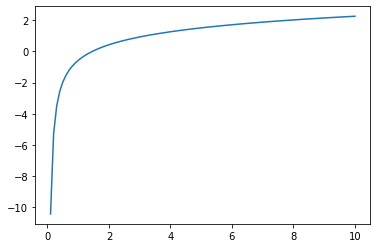

In [ ]:
plt.plot(X, Y)

$$MI(X,Y)=Ψ(k)−<Ψ(n_x+1)+Ψ(n _y+1)>+Ψ(N)$$

In [ ]:
mi=digamma(n_samples)+np.mean(digamma(k_all))-np.mean(digamma(label_counts))-np.mean(digamma(m_all + 1))
mi

0.36956281121710144

In [ ]:
x = np.array([0, 1])
y = np.array([1, 2])
pd.DataFrame({'x':x, 'y':y})

,x,y
0,0,1
1,1,2


In [ ]:
x = np.array([0, 1, 2])
y = np.array([1, 2, 1])
pd.DataFrame({'x':x, 'y':y})

,x,y
0,0,1
1,1,2
2,2,1


$$Chebyshe\_distance(P,Q) = \max{(|x_1-x_2|,|y_1-y_2|)}$$

Euclidean distance & Manhattan distance：     
$$Euclidean\_distance(P,Q) = \sqrt{(x_1-x_2)^2+(y_1-y_2)^2}$$
$$Manhattan\_distance(P,Q) = |x_1-x_2|+|y_1-y_2|$$

In [ ]:
x = np.array([0, 1])
y = np.array([1, 3])
pd.DataFrame({'x':x, 'y':y})

,x,y
0,0,1
1,1,3


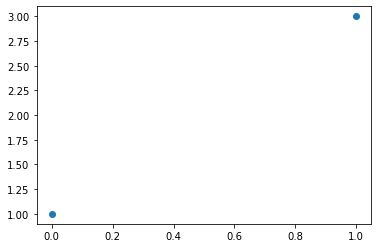

In [ ]:
plt.plot(x, y, 'o')

 Cheb distance $$\max{(|x_1-x_2|,|y_1-y_2|)}=\max{(|1-0|,|3-1|)}=2$$

&emsp;&emsp;[《Estimating mutual information》(A. Kraskov, H. Stogbauer and P. Grassberger, Phys. Rev. E 69, 2004)](https://www.researchgate.net/publication/303264392_Grassberger_Estimating_mutual_information)

In [ ]:
def _compute_mi_cc_temp(x, y, n_neighbors):
    n_samples = x.size

    x = x.reshape((-1, 1))
    y = y.reshape((-1, 1))
    xy = np.hstack((x, y))

    nn = NearestNeighbors(metric="chebyshev", n_neighbors=n_neighbors)

    nn.fit(xy)
    radius = nn.kneighbors()[0]
    radius = np.nextafter(radius[:, -1], 0)

    kd = KDTree(x, metric="chebyshev")
    nx = kd.query_radius(x, radius, count_only=True, return_distance=False)
    nx = np.array(nx) - 1.0

    kd = KDTree(y, metric="chebyshev")
    ny = kd.query_radius(y, radius, count_only=True, return_distance=False)
    ny = np.array(ny) - 1.0

    mi = (
        digamma(n_samples)
        + digamma(n_neighbors)
        - np.mean(digamma(nx + 1))
        - np.mean(digamma(ny + 1))
    )

    return max(0, mi)

In [ ]:
x = np.array([1, 2, 3])
y = np.array([2, 3, 4])
xy = np.hstack((x.reshape(-1, 1), y.reshape(-1, 1)))
xy

array([[1, 2],
       [2, 3],
       [3, 4]])

In [ ]:
NearestNeighbors(metric="chebyshev", n_neighbors=3)

NearestNeighbors(metric='chebyshev', n_neighbors=3)

In [ ]:
KDTree(x.reshape(-1, 1), metric="chebyshev")

In [ ]:
n_neighbors = 3

Text(0.5, 1.0, 'MI_0=0.10190')

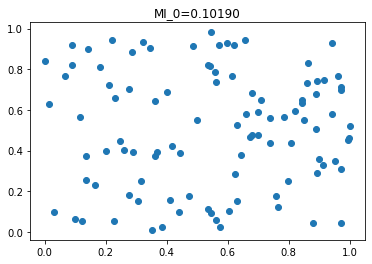

In [ ]:
np.random.seed(24)
x0 = np.random.rand(100)
y0 = np.random.rand(100)

plt.plot(x0, y0, 'o')
plt.title('MI_0={:.5f}'.format(_compute_mi_cc_temp(x0, y0, n_neighbors)))

Text(0.5, 1.0, 'MI_1=0.83846')

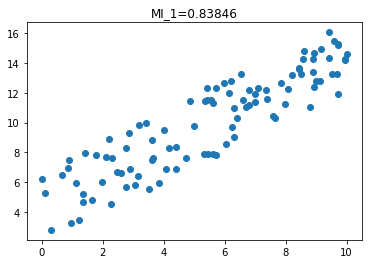

In [ ]:
np.random.seed(24)
x1 = np.random.rand(100) * 10
y1 = x1 + 2 + 5 * np.random.rand(100)

plt.plot(x1, y1, 'o')
plt.title('MI_1={:.5f}'.format(_compute_mi_cc_temp(x1, y1, n_neighbors)))

Text(0.5, 1.0, 'MI_2=0.43613')

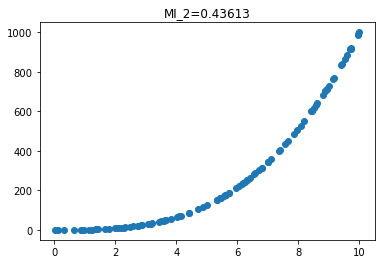

In [ ]:
np.random.seed(24)
x2 = np.random.rand(100) * 10
y2 = np.power(x2, 3) + np.random.rand(100)

plt.plot(x2, y2, 'o')
plt.title('MI_2={:.5f}'.format(_compute_mi_cc_temp(x2, y2, n_neighbors)))

Text(0.5, 1.0, 'MI=0.43438')

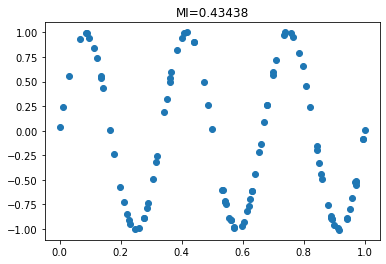

In [ ]:
np.random.seed(24)

x3 = np.random.rand(100)
y3 = np.sin(6 * np.pi * x3) + 0.01 * np.random.randn(100)

plt.plot(x3, y3, 'o')
plt.title('MI={:.5f}'.format(_compute_mi_cc_temp(x3, y3, n_neighbors)))

In [ ]:
import random

In [ ]:
random.choices?

Signature: random.choices(population, weights=None, *, cum_weights=None, k=1)
Docstring:
Return a k sized list of population elements chosen with replacement.

If the relative weights or cumulative weights are not specified,
the selections are made with equal probability.
File:      d:\anaconda3\lib\random.py
Type:      method


In [ ]:
random.seed(21)

xy = np.hstack([x3.reshape(-1, 1), y3.reshape(-1, 1)])

xy_choices = random.choices(xy,k=10)
xy_choices = np.array(xy_choices)
xy_choices

array([[ 0.67180656,  0.09093717],
       [ 0.59689144, -0.97304678],
       [ 0.03143881,  0.55263815],
       [ 0.40925902,  0.99159534],
       [ 0.30601259, -0.48945662],
       [ 0.97012789, -0.51972642],
       [ 0.36281177,  0.53398133],
       [ 0.00202327,  0.03962933],
       [ 0.91666435, -1.00899835],
       [ 0.68023886,  0.26177167]])

Text(0.5, 1.0, 'MI=0.00000')

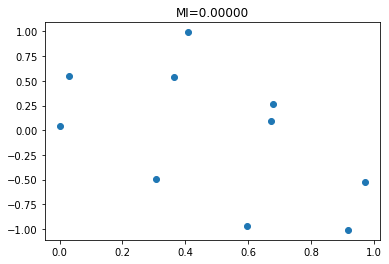

In [ ]:
plt.plot(xy_choices[:, 0], xy_choices[:, 1], 'o')
plt.title('MI={:.5f}'.format(_compute_mi_cc_temp(xy_choices[:, 0], xy_choices[:, 1], n_neighbors)))

Text(0.5, 1.0, 'MI=0.44397')

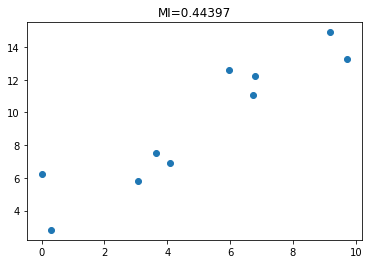

In [ ]:
random.seed(21)

xy = np.hstack([x1.reshape(-1, 1), y1.reshape(-1, 1)])

xy_choices = random.choices(xy,k=10)
xy_choices = np.array(xy_choices)

plt.plot(xy_choices[:, 0], xy_choices[:, 1], 'o')
plt.title('MI={:.5f}'.format(_compute_mi_cc_temp(xy_choices[:, 0], xy_choices[:, 1], n_neighbors)))

In [ ]:
from sklearn.feature_selection import mutual_info_regression,mutual_info_classif

In [ ]:
mutual_info_regression?

Signature:
mutual_info_regression(
    X,
    y,
    *,
    discrete_features='auto',
    n_neighbors=3,
    copy=True,
    random_state=None,
)
Docstring:
Estimate mutual information for a continuous target variable.

Mutual information (MI) [1]_ between two random variables is a non-negative
value, which measures the dependency between the variables. It is equal
to zero if and only if two random variables are independent, and higher
values mean higher dependency.

The function relies on nonparametric methods based on entropy estimation
from k-nearest neighbors distances as described in [2]_ and [3]_. Both
methods are based on the idea originally proposed in [4]_.

It can be used for univariate features selection, read more in the
:ref:`User Guide <univariate_feature_selection>`.

Parameters
----------
X : array-like or sparse matrix, shape (n_samples, n_features)
    Feature matrix.

y : array-like of shape (n_samples,)
    Target vector.

discrete_features : {'auto', bool, array-lik

- mutual_info_classif+离散变量：mutual_info_score
- mutual_info_classif+连续变量：_compute_mi_cd
- mutual_info_regression+离散变量：_compute_mi_cd
- mutual_info_regression+连续变量：_compute_mi_cc

In [ ]:
category_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [ ]:
numeric_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [ ]:
X_train_OE.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,tenure,MonthlyCharges,TotalCharges
4067,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,1.0,0.0,68,79.60,5515.80
3306,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,3,80.00,241.30
3391,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,4,19.00,73.45
3249,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,10,55.55,551.30
2674,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,4,20.05,91.45


In [ ]:
mask = [True]*len(category_cols) + [False]*len(numeric_cols)
mask

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False]

In [ ]:
mutual_info_classif(X_train_OE, y_train, discrete_features=mask)

array([1.73090078e-04, 9.13473736e-03, 1.29159500e-02, 1.24089586e-02,
       3.11949909e-06, 4.99279481e-04, 5.43286385e-02, 7.08580232e-02,
       4.78061879e-02, 4.70107520e-02, 6.57416875e-02, 3.30813850e-02,
       3.34860937e-02, 9.78731272e-02, 1.81578691e-02, 4.59939447e-02,
       7.08277944e-02, 4.57067323e-02, 4.28992124e-02])

In [ ]:
MIC = mutual_info_classif(X_train_OE, y_train, discrete_features=mask, random_state=21)
MIC = pd.Series(MIC, index=category_cols + numeric_cols)
MIC

gender              0.000173
SeniorCitizen       0.009135
Partner             0.012916
Dependents          0.012409
PhoneService        0.000003
MultipleLines       0.000499
InternetService     0.054329
OnlineSecurity      0.070858
OnlineBackup        0.047806
DeviceProtection    0.047011
TechSupport         0.065742
StreamingTV         0.033081
StreamingMovies     0.033486
Contract            0.097873
PaperlessBilling    0.018158
PaymentMethod       0.045994
tenure              0.073132
MonthlyCharges      0.047550
TotalCharges        0.042000
dtype: float64

In [ ]:
MIC.sort_values(ascending=False)

Contract            0.097873
tenure              0.073132
OnlineSecurity      0.070858
TechSupport         0.065742
InternetService     0.054329
OnlineBackup        0.047806
MonthlyCharges      0.047550
DeviceProtection    0.047011
PaymentMethod       0.045994
TotalCharges        0.042000
StreamingMovies     0.033486
StreamingTV         0.033081
PaperlessBilling    0.018158
Partner             0.012916
Dependents          0.012409
SeniorCitizen       0.009135
MultipleLines       0.000499
gender              0.000173
PhoneService        0.000003
dtype: float64

In [ ]:
KB = SelectKBest(mutual_info_classif, k=2)
KB.fit(X_train_OE[numeric_cols], y_train)
KB.scores_

array([0.0716352 , 0.04662425, 0.04380887])

In [ ]:
KB = SelectKBest(mutual_info_classif, k=2)
KB.fit(X_train_OE[numeric_cols], y_train)
KB.scores_

array([0.07371748, 0.04257017, 0.04368372])

In [ ]:
np.random.seed(21)
KB = SelectKBest(mutual_info_classif, k=2)
KB.fit(X_train_OE[numeric_cols], y_train)
KB.scores_

array([0.07313173, 0.04755022, 0.04200039])

In [ ]:
np.random.seed(21)
KB = SelectKBest(mutual_info_classif, k=2)
KB.fit(X_train_OE[numeric_cols], y_train)
KB.scores_

array([0.07313173, 0.04755022, 0.04200039])

In [ ]:
SelectName(KB)

['tenure', 'MonthlyCharges']

In [ ]:
KB.get_feature_names_out()

array(['tenure', 'MonthlyCharges'], dtype=object)

In [ ]:
A = pd.DataFrame([[1, 0, 0], [0, 0, 1]])
A

,0,1,2
0,1,0,0
1,0,0,1


In [ ]:
A.dtypes

0    int64
1    int64
2    int64
dtype: object

In [ ]:
pd.SparseDtype?

Init signature:
pd.SparseDtype(
    dtype: 'Dtype' = <class 'numpy.float64'>,
    fill_value: 'Any' = None,
)
Docstring:     
Dtype for data stored in :class:`SparseArray`.

This dtype implements the pandas ExtensionDtype interface.

Parameters
----------
dtype : str, ExtensionDtype, numpy.dtype, type, default numpy.float64
    The dtype of the underlying array storing the non-fill value values.
fill_value : scalar, optional
    The scalar value not stored in the SparseArray. By default, this
    depends on `dtype`.

    =========== ==========
    dtype       na_value
    =========== ==========
    float       ``np.nan``
    int         ``0``
    bool        ``False``
    datetime64  ``pd.NaT``
    timedelta64 ``pd.NaT``
    =========== ==========

    The default value may be overridden by specifying a `fill_value`.

Attributes
----------
None

Methods
-------
None
File:           d:\anaconda3\lib\site-packages\pandas\core\arrays\sparse\dtype.py
Type:           type
Subclasses:     


In [ ]:
int_spar = pd.SparseDtype(int, fill_value=0)

In [ ]:
A

,0,1,2
0,1,0,0
1,0,0,1


In [ ]:
A = A.astype(int_spar)
A

,0,1,2
0,1,0,0
1,0,0,1


In [ ]:
A.dtypes

0    Sparse[int32, 0]
1    Sparse[int32, 0]
2    Sparse[int32, 0]
dtype: object

In [ ]:
X_train_OE[category_cols].head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
4067,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,1.0,0.0
3306,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0
3391,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0
3249,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0
2674,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0


In [ ]:
X_train_OE[category_cols].dtypes

gender              float64
SeniorCitizen       float64
Partner             float64
Dependents          float64
PhoneService        float64
MultipleLines       float64
InternetService     float64
OnlineSecurity      float64
OnlineBackup        float64
DeviceProtection    float64
TechSupport         float64
StreamingTV         float64
StreamingMovies     float64
Contract            float64
PaperlessBilling    float64
PaymentMethod       float64
dtype: object

In [ ]:
category_part = X_train_OE[category_cols].astype(int_spar)
category_part.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
4067,0,0,1,0,1,0,0,2,2,0,2,2,2,2,1,0
3306,0,0,1,1,1,0,1,0,2,0,2,0,0,0,1,2
3391,1,0,0,0,1,0,2,1,1,1,1,1,1,0,0,3
3249,0,0,1,1,1,0,0,0,2,2,0,0,0,0,1,3
2674,0,1,0,0,1,0,2,1,1,1,1,1,1,0,0,3


In [ ]:
category_part.dtypes

gender              Sparse[int32, 0]
SeniorCitizen       Sparse[int32, 0]
Partner             Sparse[int32, 0]
Dependents          Sparse[int32, 0]
PhoneService        Sparse[int32, 0]
MultipleLines       Sparse[int32, 0]
InternetService     Sparse[int32, 0]
OnlineSecurity      Sparse[int32, 0]
OnlineBackup        Sparse[int32, 0]
DeviceProtection    Sparse[int32, 0]
TechSupport         Sparse[int32, 0]
StreamingTV         Sparse[int32, 0]
StreamingMovies     Sparse[int32, 0]
Contract            Sparse[int32, 0]
PaperlessBilling    Sparse[int32, 0]
PaymentMethod       Sparse[int32, 0]
dtype: object

In [ ]:
KB = SelectKBest(mutual_info_classif, k=10)
KB.fit(category_part, y_train)
KB.scores_

array([1.73090078e-04, 9.13473736e-03, 1.29159500e-02, 1.24089586e-02,
       3.11949909e-06, 4.99279481e-04, 5.43286385e-02, 7.08580232e-02,
       4.78061879e-02, 4.70107520e-02, 6.57416875e-02, 3.30813850e-02,
       3.34860937e-02, 9.78731272e-02, 1.81578691e-02, 4.59939447e-02])

In [ ]:
X_train_OE_spar = pd.concat([category_part, X_train_OE[numeric_cols]], axis=1)

In [ ]:
X_train_OE_spar.dtypes

gender              Sparse[int32, 0]
SeniorCitizen       Sparse[int32, 0]
Partner             Sparse[int32, 0]
Dependents          Sparse[int32, 0]
PhoneService        Sparse[int32, 0]
MultipleLines       Sparse[int32, 0]
InternetService     Sparse[int32, 0]
OnlineSecurity      Sparse[int32, 0]
OnlineBackup        Sparse[int32, 0]
DeviceProtection    Sparse[int32, 0]
TechSupport         Sparse[int32, 0]
StreamingTV         Sparse[int32, 0]
StreamingMovies     Sparse[int32, 0]
Contract            Sparse[int32, 0]
PaperlessBilling    Sparse[int32, 0]
PaymentMethod       Sparse[int32, 0]
tenure                         int64
MonthlyCharges               float64
TotalCharges                 float64
dtype: object

In [ ]:
KB = SelectKBest(mutual_info_classif, k=10)
KB.fit(X_train_OE_spar, y_train)
KB.scores_

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


array([0.01258467, 0.00622113, 0.01795915, 0.00999533, 0.        ,
       0.        , 0.04713925, 0.07712814, 0.04608793, 0.05024197,
       0.06922447, 0.02616885, 0.03397653, 0.10177979, 0.01922933,
       0.04941821, 0.07751313, 0.05026959, 0.04433634])

In [ ]:
KB = SelectKBest(mutual_info_classif, k=10)
KB.fit(X_train_OE_spar, y_train)
KB.scores_

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


array([0.        , 0.01491473, 0.00680964, 0.00386814, 0.00338383,
       0.        , 0.05816477, 0.06796908, 0.05277894, 0.04531854,
       0.06085727, 0.02753767, 0.03438466, 0.1061525 , 0.01747497,
       0.03970667, 0.07175468, 0.05023533, 0.04330436])

In [ ]:
from sklearn.metrics import normalized_mutual_info_score,adjusted_mutual_info_score

In [ ]:
NMI = pd.Series(0, index=category_cols)

for col in category_cols:
    NMI[col] = normalized_mutual_info_score(X_train_OE[col], y_train)

NMI

gender              0.000273
SeniorCitizen       0.018070
Partner             0.020389
Dependents          0.020912
PhoneService        0.000007
MultipleLines       0.000657
InternetService     0.066543
OnlineSecurity      0.088089
OnlineBackup        0.058660
DeviceProtection    0.057629
TechSupport         0.081629
StreamingTV         0.040404
StreamingMovies     0.040897
Contract            0.124614
PaperlessBilling    0.029033
PaymentMethod       0.047419
dtype: float64

In [ ]:
NMI['gender']

0.0002730741488599909

In [ ]:
AMI = pd.Series(0, index=category_cols)

for col in category_cols:
    AMI[col] = adjusted_mutual_info_score(X_train_OE[col], y_train)

AMI

gender              0.000124
SeniorCitizen       0.017886
Partner             0.020243
Dependents          0.020756
PhoneService       -0.000204
MultipleLines       0.000408
InternetService     0.066326
OnlineSecurity      0.087874
OnlineBackup        0.058442
DeviceProtection    0.057410
TechSupport         0.081413
StreamingTV         0.040182
StreamingMovies     0.040675
Contract            0.124402
PaperlessBilling    0.028886
PaymentMethod       0.047140
dtype: float64